# Rational Expectations Econometrics
This notebook follows the first empirical exercise in in Chapter 2 of Hayashi (2000). The aim of the exercise is to investigate the efficient market hypothesis (EMH) in the context of the market for U.S. Treasury bills using the paradigm of rational expectations econometrics, following Fama (1975).

## The Efficient Market Hypothesis
The EMH posits that asset prices reflect all available information. In the context of bond markets, this means that information available to market participants, such as predicted inflation, is "priced in", and is reflected in the bond yield.

More formally, let $R_t$ denote the gross nominal rate, and let ${_t \Pi_{t+1}}$ denote the market expectation of gross inflation in the next period. For simplification, assume that the net real rate is constant, equal to $r$. Then, under the EMH:
$$R_t = (1 + r_t) {_t \Pi_{t+1}}$$

Thus, letting lowercase letters denote net rates, we have the following approximation:
$$i_t = r + {_t \pi_{t+1}} \Longleftrightarrow {_t \pi_{t+1}} = i_t - r$$

Thus, in an efficient market, the bond price reflects the market's expectations of future inflation. To the extent that the market can predict inflation, the bond yield should be a predictor of future inflation. Under the assumption of rational expectations, we should have:
$$_t \pi_{t+1} = \mathbb E[\pi_{t+1} | I_t]$$
where $I_t$ denotes the information set available to agents at time $t$. This assumption requires that agents do not systematically make errors in their predictions of future inflation.

Before proceeding to the formal investigation of the hypothesis, let's load and plot the data.

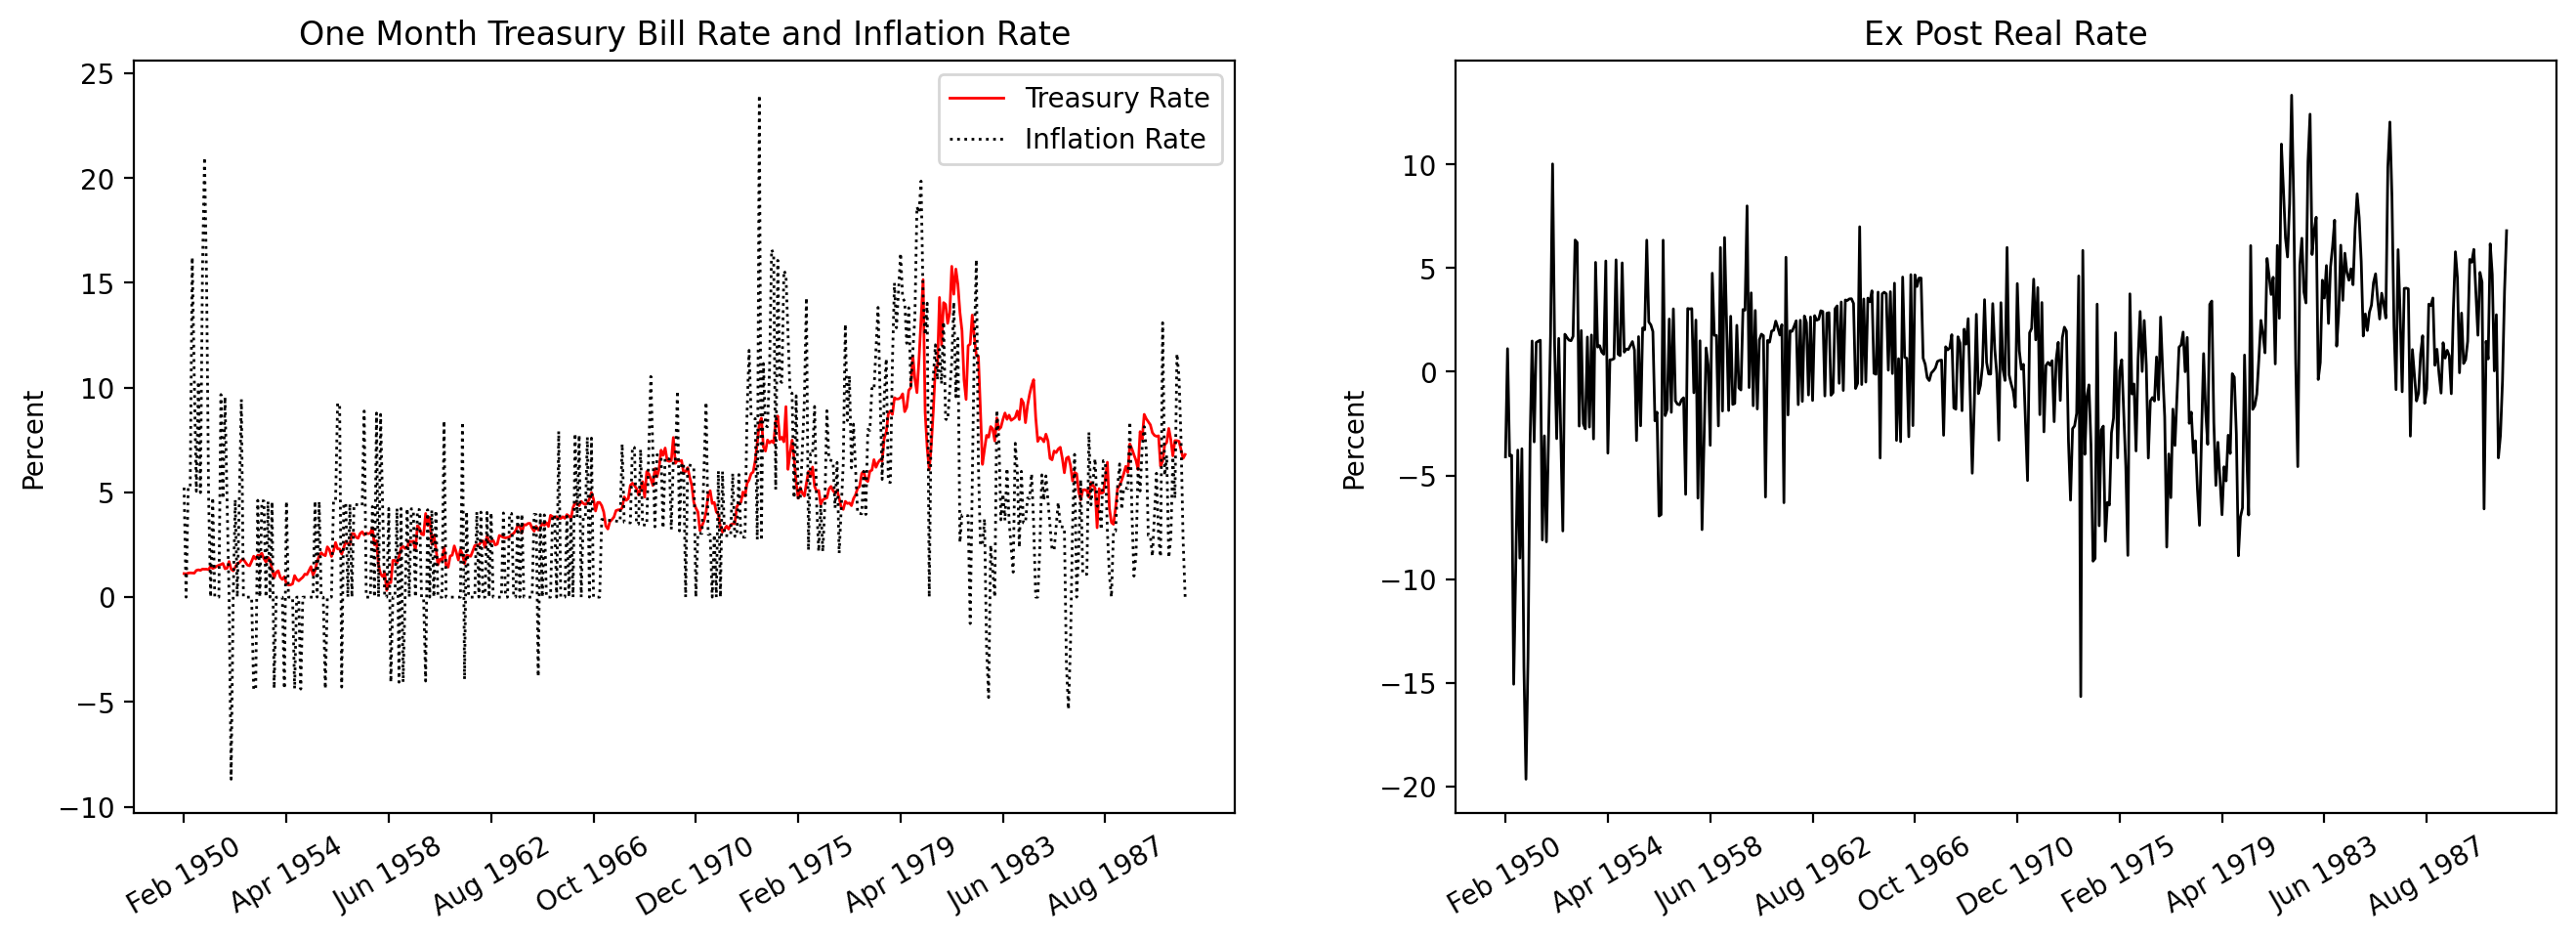

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(suppress=True)

mishkin_df = pd.read_csv('mishkin.csv')
# The dataframe contains U.S. monthly data on the one and three months inflation rates, the one and three months Treasury bill rates, and the CPI from February 1950 to
# December 1990. All rates are expressed in annual percentage terms. The data are from http://fhayashi.fc2web.com/datasets.htm.

# Combine the year and month columns into a datetime object
mishkin_df['DATE'] = pd.to_datetime(mishkin_df[['YEAR', 'MONTH']].assign(day=1))

# Format the datetime object
mishkin_df['DATE'] = mishkin_df['DATE'].dt.strftime("%b %Y")

# Consumer price index for urban consumers
cpi = mishkin_df['CPI'].to_numpy()

# One month Treasury bill rate
tb1 = mishkin_df['TB1'].to_numpy()
tb1 = np.delete(tb1, 0) # The first observation is deleted for correspondence with the inflation rate

# Compute annual inflation rate from the CPI
infl = np.empty(len(cpi) - 1)
for i in range(1, len(cpi)):
    infl[i-1] = ((cpi[i] / cpi[i-1]) ** 12 - 1) * 100

# Ex post real rate
r = tb1 - infl

# Plot the data
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plotting
axs[0].plot(tb1, label="Treasury Rate", color='red', linewidth=1)
axs[0].plot(infl, label="Inflation Rate", linestyle='dotted', linewidth=1, color='black')
axs[1].plot(r, linewidth=1, color='black')

# Formatting
axs[0].set_title('One Month Treasury Bill Rate and Inflation Rate')

x_ticks = mishkin_df.iloc[::50]["DATE"]
axs[0].set_xticks(x_ticks.index, x_ticks, rotation=30)
axs[0].set_ylabel('Percent')
axs[0].legend()

axs[1].set_title('Ex Post Real Rate')
axs[1].set_xticks(x_ticks.index, x_ticks, rotation=30)
axs[1].set_ylabel('Percent');

## Testing the EMH
To simplify the analysis, we will assume further that the ex-ante real rate is constant: $_t r_{t+1} = r$. Let $\eta_{t+1} = \pi_{t+1} - {_t \pi_{t+1}}$ denote the inflation forecast error. Since $_t \pi_{t+1} = \mathbb E[\pi_{t+1} | I_t]$ under the EMH, it is easily seen that $\mathbb E[\eta_t | I_t] = 0$. Moreover, since past forecast errors are included in the information set, it immediately follows that the inflation forecast error is a martingale difference sequence, and is hence nonautocorrelated.

Next, notice we can write the ex post real rate as $r_{t+1} = R_t - \pi_{t+1} = i_t - {_t \pi_{t+1}} - (\pi_{t+1} - {_t \pi_{t+1}}) = r - \eta_{t+1}$. Thus, the ex post real rate is a constant plus a martingale difference sequence, and is hence nonautocorrelated. This will be the basis of our first test of the EMH.

The other significant implication of the EMH is thhat the nominal rate is an optimal predictor of future inflation, given the information set. This can be seen by writing $\mathbb E[\pi_{t+1}|I_t] = \mathbb E[i_t - r + \eta_{t+1} | I_t]$, which implies $\mathbb E[\pi_{t+1} | I_t] = -r + i_t$. We can test this implication by regressing future inflation on the nominal rate, and testing whether the coefficient on the nominal rate is equal to $1$.

### Autocorrelation of the ex post real rate
To test for nonautocorrelation in the ex post real rate, we can use two approaches.

The first is to calculate the sample autocorrelations and measure their significance, under the null hypothesis that the autocorrelations are zero, using their asymptotic distribution. Recall:
$$r_t = r - \eta_t$$
where $\eta_t$ is a martingale difference sequence. If we assume that $\eta_t$ is a stationary process with own conditional homoskedasticity, then the asymptotic distribution of the sample autocorrelations is:
$$\sqrt T \hat \rho \xrightarrow{d} N(0, I)$$
where $\hat \rho = (\hat \rho_1, \ldots, \hat \rho_p)$ is the vector of sample autocorrelations, for some $p \in \mathbb N$, and $T$ denotes the sample size. Hence, each sample autocorrelation, scaled by the standard error $1/\sqrt{T}$ is appproximately standard normal.

The second approach is to use the Ljung-Box test, which tests for nonautocorrelation up to lag $p$. The Ljung-Box test statistic and its asymptotic distribution (under the same assumption as above) are given by:
$$Q = T(T+2) \sum_{k=1}^p \frac{\hat \rho_k^2}{T-k} \xrightarrow{d} \chi^2(p)$$

The tests are conducted using the data from January 1953 to July 1971.

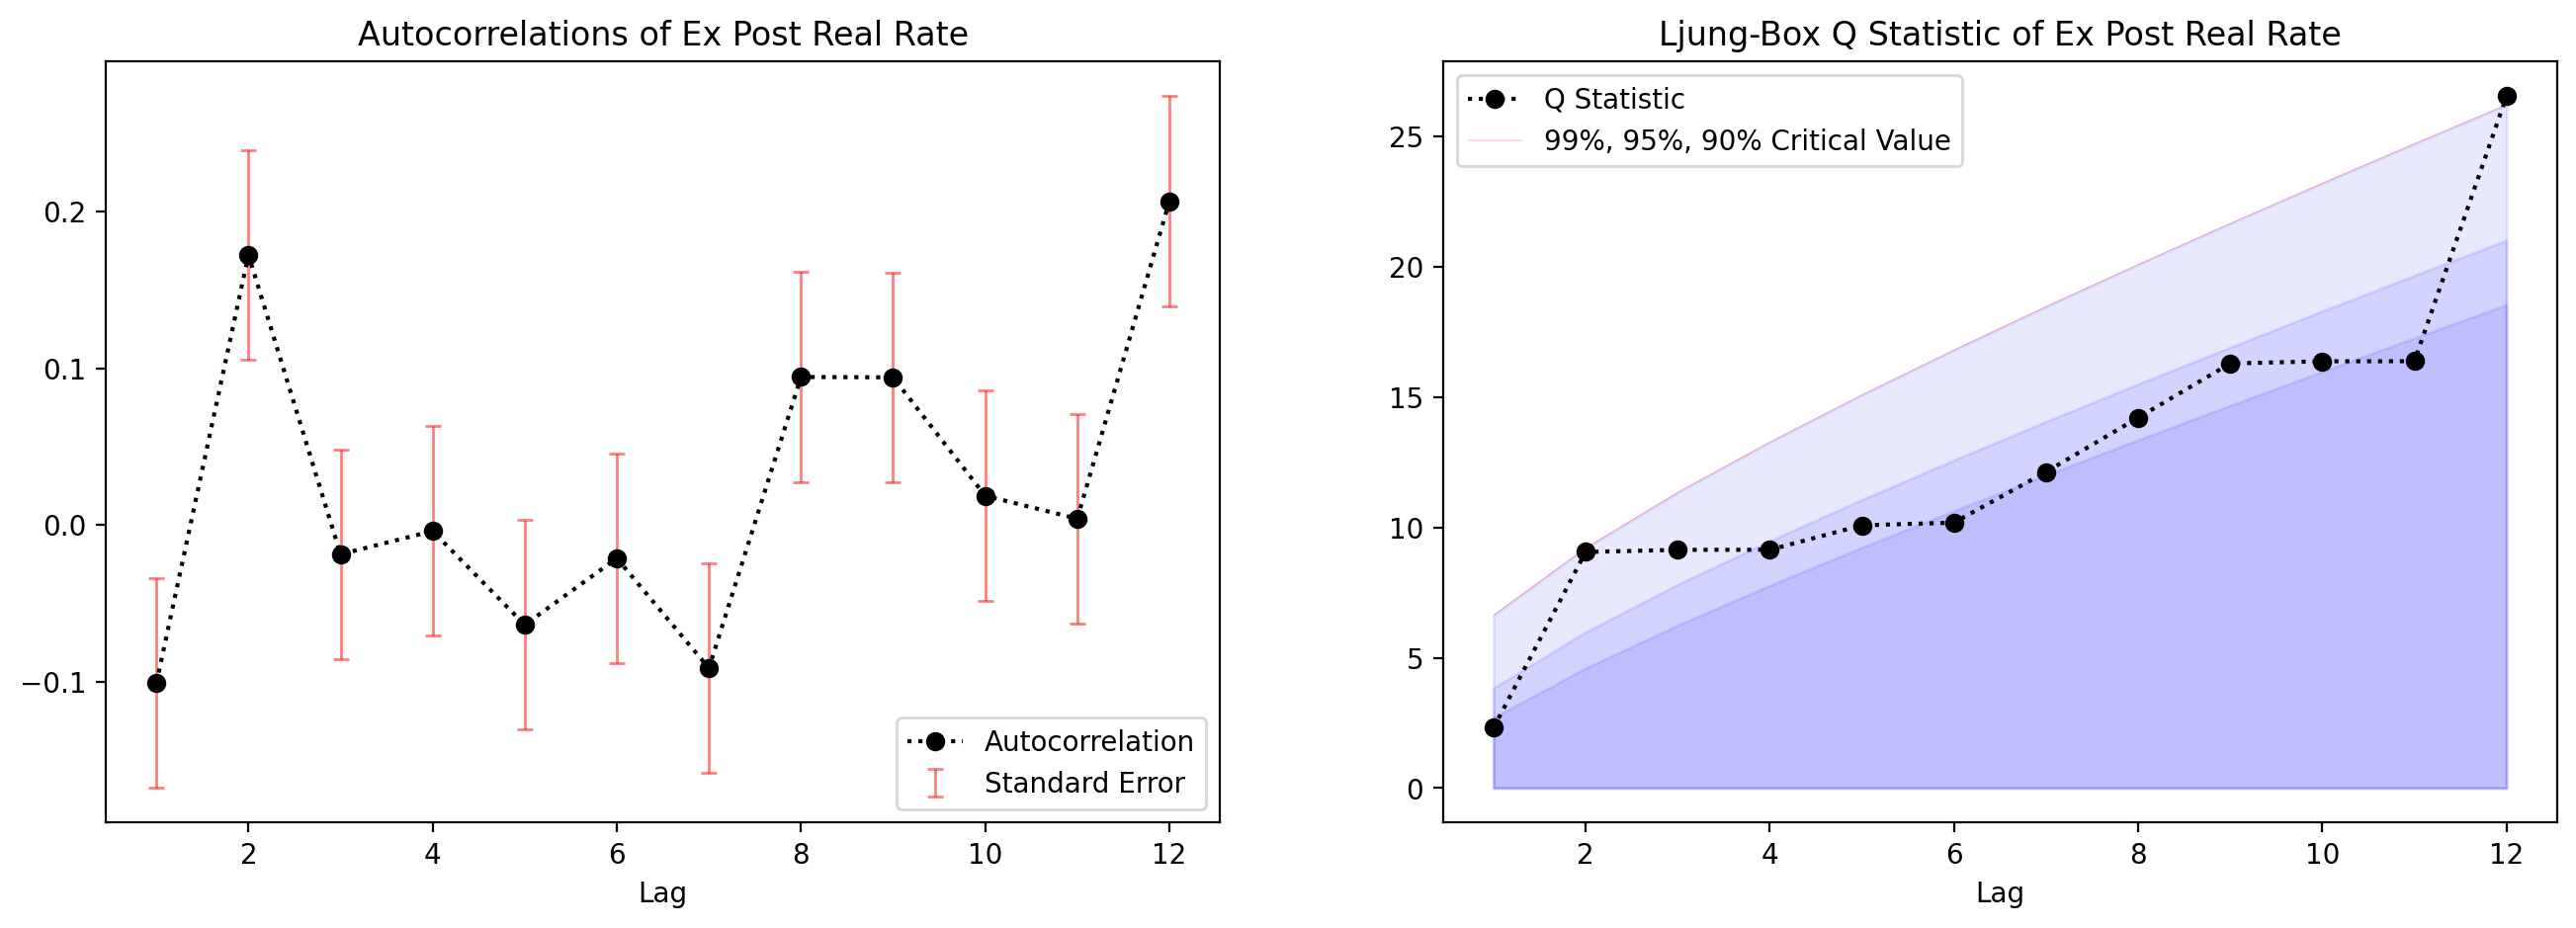

Critical values for the autocorrelations of the ex post real rate:
95%: 0.131
99%: 0.172


In [78]:
# Define function to calculate the autocovariance
def autocovariance(x, lag):
    x = x - np.mean(x)

    if lag == 0:
        return np.sum(x * x) / len(x)
    else:
        return np.sum(x[lag:] * x[:-lag]) / len(x)
    
# Define function to calculate autocorrelation of numpy array
def autocorrelation(x, lag):
    return autocovariance(x, lag) / autocovariance(x, 0)

# Define function to calculate Ljung-Box Q statistic for a given lag length –– returns the Q statistic and the p-value
def ljung_box(x, lag):
    n = len(x)
    r = np.empty(lag)
    for i in range(lag):
        r[i] = autocorrelation(x, i+1)

    Q = n * (n + 2) * np.sum(r ** 2 / (n - np.arange(1, lag+1)))

    p = (1 - chi2.cdf(Q, lag)) * 100

    return [Q, p]

# Calculate autocorrelations of ex post real rate subsample
r_subsample = r[34: 257]

r_autocorrs = np.empty(12)
r_ljung_box_q = np.empty(12)
r_ljung_box_p = np.empty(12)

for i in range(12):
    r_autocorrs[i] = autocorrelation(r_subsample, i+1)
    r_ljung_box_q[i] = ljung_box(r_subsample, i+1)[0]
    r_ljung_box_p[i] = ljung_box(r_subsample, i+1)[1]

# Plot autocorrelations and Ljung-Box Q statistic
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plotting
axs[0].errorbar(np.arange(1, 13), r_autocorrs, yerr=np.sqrt(1 / len(r_subsample)), linestyle="None", color='red', linewidth=1, capsize=3, label='Standard Error', alpha=0.5)
axs[0].plot(np.arange(1, 13), r_autocorrs, marker='o', linestyle='dotted', color='black', label='Autocorrelation');

axs[1].plot(np.arange(1, 13), r_ljung_box_q, marker='o', linestyle='dotted', color='black', label='Q Statistic');
axs[1].fill_between(np.arange(1, 13), 0, chi2.ppf(0.9, np.arange(1, 13)), color="blue", alpha=0.09);
axs[1].fill_between(np.arange(1, 13), 0, chi2.ppf(0.95, np.arange(1, 13)), color="blue", alpha=0.09);
axs[1].plot(np.arange(1, 13), chi2.ppf(0.99, np.arange(1, 13)), color='red', linewidth=0.1, label='99%, 95%, 90% Critical Value');
axs[1].fill_between(np.arange(1, 13), 0, chi2.ppf(0.99, np.arange(1, 13)), color="blue", alpha=0.09);

# Formatting
axs[0].set_xlabel('Lag')
axs[0].set_title('Autocorrelations of Ex Post Real Rate')
axs[0].legend();

axs[1].set_xlabel('Lag')
axs[1].set_title('Ljung-Box Q Statistic of Ex Post Real Rate')
axs[1].legend();

plt.show();

print("Critical values for the autocorrelations of the ex post real rate:")
print(f"95%: {norm.ppf(0.975) / np.sqrt(len(r_subsample)):.3f}")
print(f"99%: {norm.ppf(0.995) / np.sqrt(len(r_subsample)):.3f}")

Based on the sample autocorrelations, we cannot reject the null hypothesis of nonautocorrelation at any reasonable significance level. The Ljung-Box test statistics also prive a similar indication. Thus, we cannot reject the null hypothesis of nonautocorrelation, and the ex post real rate appears to be consistent with the EMH.

### The Nominal Rate as a Predictor of Future Inflation
Next, we turn to the regression of future inflation on the nominal rate. The regression is conducted using the data from January 1953 to July 1971. The model specification is:
$$\pi_{t+1} = \beta_1 + \beta_2 i_t + \eta_{t+1} \Longleftrightarrow y_t = x_t' \beta + \varepsilon_t$$
where $y_t = \pi_{t+1}$, $x_t = \begin{bmatrix} 1 & i_t \end{bmatrix}'$, $\beta = \begin{bmatrix} \beta_1 & \beta_2 \end{bmatrix}'$, and $\varepsilon_t = \eta_{t+1}$.

Under the null hypothesis, $\beta_2 = 1$. We can test this using the t-statistic.

Before proceeding with the regression and the hypothesis test, we need to verify that the model satisfies assumptions which imply that the t-statistic has the standard asymptotic distribution. A sufficient set of assumptions are:
1. Linearity: there is $\beta \in \mathbb R^2$ such that $y_t = x_t' \beta + \varepsilon_t$.
2. Ergodic stationarity: $\{(y_t, x_t)\}_{t \in \mathbb N}$ is a jointly stationary ergodic process.
3. Contemporaneously orthogonal regressors: $\mathbb E[x_t \varepsilon_t] = 0$.
4. Full rank: $\mathbb E[x_t x_t']$ is has full column rank.
5. $\{x_t \varepsilon_t\}_{t \in \mathbb N}$ is a martingale difference sequence with finite second moments.

Under our hypothesis, $\pi_{t+1} = i_t - r$, so the linearity assumption is trivially satisfied. Next, notice that $\mathbb E[i_t \eta_{t+1}] = \mathbb E[\mathbb E(i_t \eta_{t+1} | I_t)]$ by the law of iterated expectations. We previously showed $\mathbb E[\eta_{t+1} | I_i] = 0$, it follows that the regressors are contemporanesouly orthogonal. It can be easily checked that $\mathbb E[x_t x_t']$ having full rank is equivalent to the variance of the interest rate being strictly positive, which is true since there is variation in the data. Finally, since $\mathbb E[\eta_t | I_t]$ is a martingale difference sequence and the interest rates and previous forecast errors are included in the information set, it follows that $\{i_t \varepsilon_t\}_{t \in \mathbb N}$ is a martingale difference sequence. We assume the remaining assumptions – ergodic stationarity and finite second moments – are satisfied.

Having verified the assumptions, we now proceed with the regression.

First, we fit the model and compute heteroskedasticity-robust standard errors using three different methods. Notice, the asymptotic distribution of the OLS estimator is:
$$T^{\frac 12} (\hat \beta - \beta) \xrightarrow{d} \mathcal N(0, \text{Asy.} \mathbb V[\hat \beta])$$
where the asymptotic variance, $\text{Asy.} \mathbb V[\hat \beta]$, is given by:
$${\left(\mathbb E[x_t x_t']\right)}^{-1} \mathbb E[\varepsilon_t^2 x_t x_t] {\left(\mathbb E[x_t x_t']\right)}^{-1}$$

The heteroskedasticity robus standard errors are based on the corresponding sample averages of the asymptotic variance, subject to some finite sample corrections:
$$\widehat{\text{Asy.} \mathbb V_k[\hat \beta]} = {\left(T^{-1} \sum_{t=1}^T x_t x_t'\right)}^{-1} \widehat {\mathbb E_k [\varepsilon_t^2 x_t x_t]} {\left(T{-1} \sum_{t=1}^T x_t x_t'\right)}^{-1}$$

where:
$$
\begin{align*}
\widehat {\mathbb E_1 [\varepsilon_t^2 x_t x_t]} = {\left(T^{-1} \sum_{t=1}^T \hat \varepsilon_t^2 x_t x_t'\right)} &&
\widehat {\mathbb E_2 [\varepsilon_t^2 x_t x_t]} = {\left([T - 2]^{-1} \sum_{t=1}^T \hat \varepsilon_t^2 x_t x_t'\right)} &&
\widehat {\mathbb E_3 [\varepsilon_t^2 x_t x_t]} = {\left(T^{-1} \sum_{t=1}^T (1 - p_t)^{-d}\hat \varepsilon_t^2 x_t x_t'\right)}
\end{align*}
$$
where $p_t = x_t' (X'X)^{-1} x_t$ and $d = 1$ or $2$. The first approach is the usual heteroskedasticity robust standard errors, and the second and third approaches incorporate the degrees of freedom corrections suggested by Davidson and MacKinnon (1993), who suggest that these improve the power of the tests for finite samples.

The corresponding $t$-statistics for testing $\beta_1 = 1$ and their asymptotic distribution under the null are given by:
$$t_k = \frac{T^{\frac 12} (\hat \beta_1 - 1)}{\sqrt{\widehat{\text{Asy.} \mathbb V_k{\hat \beta_1}}}} \xrightarrow{d} N(0, 1)$$

In [79]:
# Define a class for the regression
class NominalRateRegression:
    def __init__(self, y, X):
        self.y = y
        self.X = X
        self.T = len(y)
        self.K = len(X[0])
        self.beta_hat = self.compute_beta_hat()
        self.resids = self.compute_resids()
        self.Sxx = self.compute_Sxx()
        self.Sxx_inv = np.linalg.inv(self.Sxx)
        self.S_hat_1 = self.compute_S_hat_1()
        self.S_hat_2 = self.compute_S_hat_2()
        self.S_hat_3 = self.compute_S_hat_3()
        self.V_hat_1 = self.compute_V_hat_k(self.S_hat_1)
        self.V_hat_2 = self.compute_V_hat_k(self.S_hat_2)
        self.V_hat_3 = self.compute_V_hat_k(self.S_hat_3)
        self.se_1 = self.compute_se_k(self.V_hat_1)
        self.se_2 = self.compute_se_k(self.V_hat_2)
        self.se_3 = self.compute_se_k(self.V_hat_3)
        self.t_1 = self.compute_t_k(self.se_1)
        self.t_2 = self.compute_t_k(self.se_2)
        self.t_3 = self.compute_t_k(self.se_3)
        self.p_1 = self.compute_p_k(self.t_1)
        self.p_2 = self.compute_p_k(self.t_2)
        self.p_3 = self.compute_p_k(self.t_3)
    
    def compute_beta_hat(self):
        beta_hat = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y
        return beta_hat
    
    def compute_resids(self):
        resids = self.y - self.X @ self.beta_hat
        return resids
    
    def compute_Sxx(self):
        Sxx = self.X.T @ self.X / self.T
        return Sxx

    def compute_S_hat_1(self):
        S_hat_1 = self.X.T @ np.diag(self.resids ** 2) @ self.X / self.T
        return S_hat_1

    def compute_S_hat_2(self):
        S_hat_2 = self.X.T @ np.diag(self.resids ** 2) @ self.X / (self.T - 2)
        return S_hat_2

    def compute_S_hat_3(self):
        p = np.empty(self.T)
        for i in range(self.T):
            p[i] = self.X[i].T @ self.Sxx_inv @ self.X[i] / self.T
        summer = np.zeros((self.K, self.K))
        d = 1
        for i in range(self.T):
            summer += (1 - p[i])**(-d) * self.resids[i]**2 * np.outer(self.X[i], self.X[i].T)

        S_hat_3 = summer / self.T
        return S_hat_3
    
    def compute_V_hat_k(self, S_hat):
        V_hat_k = self.Sxx_inv @ S_hat @ self.Sxx_inv
        return V_hat_k
    
    def compute_se_k(self, V_hat):
        se_k = np.sqrt(np.diag(V_hat) / self.T)
        return se_k

    def compute_t_k(self, se_k):
        t_k = (self.beta_hat[1] - 1) / se_k[1]
        return t_k

    def compute_p_k(self, t_k):
        p_k = (1 - norm.cdf(np.abs(t_k))) * 2
        return p_k
    
    def summary(self):
        return(f"""
            Standard Heteroskedasticity-Robust Standard Errors
            ---------------------------------------------------------------------------
            Variable\t\tCoefficient\t\tStandard Error
            Constant\t\t{self.beta_hat[0]:.4f}\t\t\t{self.se_1[0]:.4f}
            Nominal rate\t{self.beta_hat[1]:.4f}\t\t\t{self.se_1[1]:.4f}

            t-statistic for beta_1 = 1: {self.t_1:.4f}
            p-value for beta_1 = 1: {self.p_1:.4f}
            ---------------------------------------------------------------------------

            Degrees of Freedom Corrected Heteroskedasticity-Robust Standard Errors (1)
            ---------------------------------------------------------------------------
            Variable\t\tCoefficient\t\tStandard Error
            Constant\t\t{self.beta_hat[0]:.4f}\t\t\t{self.se_2[0]:.4f}
            Nominal rate\t{self.beta_hat[1]:.4f}\t\t\t{self.se_2[1]:.4f}

            t-statistic for beta_1 = 1: {self.t_2:.4f}
            p-value for beta_1 = 1: {self.p_2:.4f}
            ---------------------------------------------------------------------------

            Degrees of Freedom Corrected Heteroskedasticity-Robust Standard Errors (2)
            ---------------------------------------------------------------------------
            Variable\t\tCoefficient\t\tStandard Error
            Constant\t\t{self.beta_hat[0]:.4f}\t\t\t{self.se_3[0]:.4f}
            Nominal rate\t{self.beta_hat[1]:.4f}\t\t\t{self.se_3[1]:.4f}

            t-statistic for beta_1 = 1: {self.t_3:.4f}
            p-value for beta_1 = 1: {self.p_3:.4f}
            ---------------------------------------------------------------------------
        """)

# Define the data matrix and the dependent variable
X = sm.add_constant(tb1[34: 257])
y = infl[34: 257]

reg = NominalRateRegression(y, X)
print(reg.summary())


            Standard Heteroskedasticity-Robust Standard Errors
            ---------------------------------------------------------------------------
            Variable		Coefficient		Standard Error
            Constant		-0.8678			0.4312
            Nominal rate	1.0147			0.1122

            t-statistic for beta_1 = 1: 0.1310
            p-value for beta_1 = 1: 0.8958
            ---------------------------------------------------------------------------

            Degrees of Freedom Corrected Heteroskedasticity-Robust Standard Errors (1)
            ---------------------------------------------------------------------------
            Variable		Coefficient		Standard Error
            Constant		-0.8678			0.4332
            Nominal rate	1.0147			0.1127

            t-statistic for beta_1 = 1: 0.1304
            p-value for beta_1 = 1: 0.8963
            ---------------------------------------------------------------------------

            Degrees of Freedom Corrected Heteroskedas

The results indicate that we cannot reject the null hypothesis that the nominal rate is an optimal predictor of future inflation, given the information set. Thus, the data is consistent with the EMH.

Next, we conduct the Breusch-Godfrey test for autocorrelation in the residuals. The test statistic and its asymptotic distribution are given by:
$$TR^2 \xrightarrow{d} \chi^2(p)$$
where $R^2$ is formed from the auxiliary regression of the residuals on the original variables and the lagged residuals, and $p$ is the number of lags included in the auxiliary regression of $\hat \varepsilon_t$ on $x_t$ and $\hat \varepsilon_{t-1}, \ldots, \hat \varepsilon_{t-p}$.

In [80]:
# Define the data matrix – original regressors and lagged residuals from the original regression. The number of lags is 12.
Xi = X
resids = reg.resids
for i in range(12):
    T = len(resids)
    lagged_resids = np.zeros(T)

    for k in range(T - i - 1):
        lagged_resids[k + i + 1] = resids[k]
    
    Xi = np.column_stack((Xi, lagged_resids))

aux_model = sm.OLS(resids, Xi)
aux_reg = aux_model.fit()

bg = aux_reg.nobs * aux_reg.rsquared
p_bg = chi2.sf(bg, 12)

print(aux_reg.summary())
print(f"Bresuch-Godfrey test statistic: {bg:.4f}")
print(f"p-value: {p_bg:.4f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.215
Date:                Fri, 08 Sep 2023   Prob (F-statistic):             0.0101
Time:                        08:31:21   Log-Likelihood:                -534.03
No. Observations:                 223   AIC:                             1096.
Df Residuals:                     209   BIC:                             1144.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0371      0.418     -0.089      0.9

Since the p value is 0.0077, we reject the null hypothesis of no autocorrelation in the residuals at the 1% significance level.